In [1]:
# ======================================================
# 00. Environment and GPU Check
# ======================================================

import os, sys, platform, torch

print("✅ Environment setup check:")
print(f"Python version : {sys.version.split()[0]}")
print(f"OS            : {platform.system()} {platform.release()}")
print(f"Working dir   : {os.getcwd()}")

# Detect GPU availability and show CUDA details
if torch.cuda.is_available():
    print(f"🧠 GPU device  : {torch.cuda.get_device_name(0)}")
    print(f"CUDA version   : {torch.version.cuda}")
    print(f"PyTorch build  : {torch.__version__}")
    device = torch.device("cuda")
else:
    print("⚠️ No GPU detected — running on CPU.")
    device = torch.device("cpu")

print("=" * 60)


✅ Environment setup check:
Python version : 3.12.8
OS            : Windows 11
Working dir   : d:\IIT\L6\FYP\chagas-ecg-detection\notebooks
🧠 GPU device  : NVIDIA GeForce RTX 3050 6GB Laptop GPU
CUDA version   : 11.8
PyTorch build  : 2.7.1+cu118


In [2]:
# ======================================================
# 01. Imports & Configuration
# ======================================================

import math
import time
import json
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

# ---- Paths (Windows-first; fall back to Linux path) ----
WIN_SPLIT_DIR = Path(r"D:\\IIT\\L6\\FYP\\chagas-ecg-detection\\data\\processed\\ptbxl\\records_split")
LIN_SPLIT_DIR = Path("/mnt/data/ptbxl/records_split")
SPLIT_DIR = WIN_SPLIT_DIR if WIN_SPLIT_DIR.exists() else LIN_SPLIT_DIR

if not SPLIT_DIR.exists():
    raise FileNotFoundError(f"Could not find records_split directory at: {WIN_SPLIT_DIR} or {LIN_SPLIT_DIR}")

print(f"📁 Using processed split directory: {SPLIT_DIR}")

# ---- Output / logs ----
OUTPUT_DIR = Path("experiments/vit/results")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

CHECKPOINT_BEST = OUTPUT_DIR / "vit_best.pt"
CHECKPOINT_LAST = OUTPUT_DIR / "vit_last.pt"
LOG_CSV = OUTPUT_DIR / "train_log.csv"
LABEL_MAP_JSON = OUTPUT_DIR / "label_mapping.json"
CONFIG_JSON = OUTPUT_DIR / "config.json"

# ---- Core hyperparameters (balanced for 6 GB GPU) ----
PATCH_LEN = 50             # time samples per patch (1000 / 50 = 20 patches)
EMBED_DIM = 256            # embedding dimension
NUM_LAYERS = 4             # transformer depth
NUM_HEADS = 4              # attention heads
MLP_RATIO = 4              # FFN expansion
DROPOUT = 0.1

BATCH_SIZE = 32
LEARNING_RATE = 3e-4
WEIGHT_DECAY = 1e-4
EPOCHS = 20                # safe start; extend later
GRAD_CLIP_NORM = 1.0

# Reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

print("✅ Config loaded.")


📁 Using processed split directory: D:\IIT\L6\FYP\chagas-ecg-detection\data\processed\ptbxl\records_split
✅ Config loaded.


In [3]:
# ======================================================
# 02. Label Encoding & Class Weights
# ======================================================

import json
import numpy as np
from pathlib import Path

def load_split_labels(split_dir: Path):
    """Load labels.npy for each split (train/val/test)."""
    labels_path = split_dir / "labels.npy"
    if not labels_path.exists():
        raise FileNotFoundError(f"Missing labels file: {labels_path}")
    return np.load(labels_path, allow_pickle=True)

# --- Load label arrays from your processed folders ---
train_labels = load_split_labels(SPLIT_DIR / "train")
val_labels   = load_split_labels(SPLIT_DIR / "val")
test_labels  = load_split_labels(SPLIT_DIR / "test")

# --- Build consistent mapping (string → int) ---
unique_labels = sorted(set(train_labels.tolist()))
label_to_idx = {lbl: i for i, lbl in enumerate(unique_labels)}
idx_to_label = {i: lbl for lbl, i in label_to_idx.items()}
num_classes = len(unique_labels)

print(f"🔤 Label mapping (train-set defined): {label_to_idx}")
print(f"📊 Num classes: {num_classes}")

# --- Encode all splits ---
def encode_labels(raw_labels, mapping):
    ids = []
    for lbl in raw_labels:
        ids.append(mapping.get(lbl, -1))
    return np.array(ids, dtype=np.int64)

y_train = encode_labels(train_labels, label_to_idx)
y_val   = encode_labels(val_labels,   label_to_idx)
y_test  = encode_labels(test_labels,  label_to_idx)

# --- Filter out unknown labels (in case val/test has unseen classes) ---
train_mask = y_train >= 0
val_mask   = y_val >= 0
test_mask  = y_test >= 0

if not train_mask.all():
    print("⚠️ Some training samples had unknown labels — they will be dropped.")
if not val_mask.all():
    print("⚠️ Some validation samples had unknown labels — they will be dropped.")
if not test_mask.all():
    print("⚠️ Some test samples had unknown labels — they will be dropped.")

# --- Compute inverse-frequency class weights for imbalanced data ---
class_counts = np.bincount(y_train[train_mask], minlength=num_classes)
N = class_counts.sum()
C = num_classes
class_weights = (N / (C * np.maximum(class_counts, 1))).astype(np.float32)
class_weights_t = torch.tensor(class_weights, device=device)

print("📈 Class counts:", class_counts.tolist())
print("⚖️ Class weights:", class_weights.tolist())

# --- Save label map & config for reproducibility ---
with open(LABEL_MAP_JSON, "w", encoding="utf-8") as f:
    json.dump({"label_to_idx": label_to_idx, "idx_to_label": idx_to_label}, f, indent=2)
with open(CONFIG_JSON, "w", encoding="utf-8") as f:
    json.dump({
        "PATCH_LEN": PATCH_LEN, "EMBED_DIM": EMBED_DIM, "NUM_LAYERS": NUM_LAYERS,
        "NUM_HEADS": NUM_HEADS, "MLP_RATIO": MLP_RATIO, "DROPOUT": DROPOUT,
        "BATCH_SIZE": BATCH_SIZE, "LEARNING_RATE": LEARNING_RATE, "EPOCHS": EPOCHS,
        "SEED": SEED
    }, f, indent=2)

print("💾 Saved label mapping and config to:", LABEL_MAP_JSON, "and", CONFIG_JSON)


🔤 Label mapping (train-set defined): {'CD': 0, 'HYP': 1, 'MI': 2, 'NORM': 3, 'STTC': 4, 'UNKNOWN': 5}
📊 Num classes: 6
📈 Class counts: [3528, 1408, 2828, 7263, 2057, 334]
⚖️ Class weights: [0.8228458166122437, 2.0617897510528564, 1.0265204906463623, 0.39969709515571594, 1.4112786054611206, 8.691617012023926]
💾 Saved label mapping and config to: experiments\vit\results\label_mapping.json and experiments\vit\results\config.json


In [4]:
# ======================================================
# 03. PyTorch Dataset (Lazy ECG Loader)
# ======================================================

import torch
from torch.utils.data import Dataset
import numpy as np
from pathlib import Path

class PTBXLRecordsDataset(Dataset):
    """
    Lazy-loading Dataset for PTB-XL per-record ECG files.
    Each file contains a normalized ECG array (12 × time_length).
    Labels are integer-encoded (0...num_classes-1).
    """
    def __init__(self, root: Path, split: str, y_encoded: np.ndarray, keep_mask: np.ndarray):
        self.root = root
        self.split = split
        split_dir = self.root / split

        # List all data files except labels.npy
        all_files = sorted([p for p in split_dir.glob("*.npy") if p.name != "labels.npy"])

        # Apply mask (to drop unknown labels)
        self.indices = np.where(keep_mask)[0]
        self.files = [all_files[i] for i in self.indices]
        self.labels = y_encoded[keep_mask]

        # Sanity check
        if len(self.files) == 0:
            raise RuntimeError(f"No samples left in split '{split}' after filtering.")

        # Inspect one sample to capture shape
        sample = np.load(self.files[0], allow_pickle=True)
        self.leads, self.length = sample.shape[0], sample.shape[1]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        """
        Loads one ECG as float32 tensor and its label.
        Returns: (tensor[12, time_length], label_int)
        """
        x = np.load(self.files[idx]).astype(np.float32)
        y = int(self.labels[idx])
        return torch.from_numpy(x), y


# --- Instantiate datasets for all splits ---
train_ds = PTBXLRecordsDataset(SPLIT_DIR, "train", y_train, train_mask)
val_ds   = PTBXLRecordsDataset(SPLIT_DIR, "val",   y_val,   val_mask)
test_ds  = PTBXLRecordsDataset(SPLIT_DIR, "test",  y_test,  test_mask)

print(f"TRAIN: {len(train_ds)} samples | shape {train_ds.leads}×{train_ds.length}")
print(f"VAL  : {len(val_ds)} samples | shape {val_ds.leads}×{val_ds.length}")
print(f"TEST : {len(test_ds)} samples | shape {test_ds.leads}×{test_ds.length}")


TRAIN: 17418 samples | shape 12×1000
VAL  : 2183 samples | shape 12×1000
TEST : 2198 samples | shape 12×1000


In [5]:
# ======================================================
# 04. DataLoaders
# ======================================================

from torch.utils.data import DataLoader
import os

# ✅ DataLoader parameters
# - pin_memory speeds up GPU transfer
# - num_workers controls parallelism in data loading
#   On Windows, set to 0 (to avoid multi-process file I/O issues)
#   On Linux, you can safely set 2–4 for faster loading

num_workers = 0 if os.name == "nt" else 2  

train_loader = DataLoader(
    train_ds, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=num_workers, 
    pin_memory=True
)

val_loader = DataLoader(
    val_ds, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=num_workers, 
    pin_memory=True
)

test_loader = DataLoader(
    test_ds, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=num_workers, 
    pin_memory=True
)

# ✅ Sanity check
print(f"📦 Train batches: {len(train_loader)}")
print(f"📦 Val batches  : {len(val_loader)}")
print(f"📦 Test batches : {len(test_loader)}")


📦 Train batches: 545
📦 Val batches  : 69
📦 Test batches : 69


In [6]:
# ======================================================
# 05-A. Patch Embedding (ECG → Time-Patch Tokens)
# ======================================================

import torch
import torch.nn as nn

class PatchEmbed(nn.Module):
    """
    Converts a (B, leads, T) ECG into a sequence of P patches.
    Each patch of shape (leads × patch_len) is flattened and projected to EMBED_DIM.
    """
    def __init__(self, leads: int, patch_len: int, embed_dim: int):
        super().__init__()
        self.leads = leads
        self.patch_len = patch_len
        self.in_dim = leads * patch_len
        self.proj = nn.Linear(self.in_dim, embed_dim)

    def forward(self, x):
        # x shape: (B, leads, T)
        B, L, T = x.shape
        assert L == self.leads, f"Expected {self.leads} leads, got {L}"
        assert T % self.patch_len == 0, "Time length must be divisible by PATCH_LEN"

        P = T // self.patch_len  # number of patches
        # split time dimension into patches of length patch_len
        x = x.unfold(dimension=2, size=self.patch_len, step=self.patch_len)  # (B, L, P, patch_len)
        x = x.permute(0, 2, 1, 3).contiguous()                              # (B, P, L, patch_len)
        x = x.view(B, P, self.in_dim)                                       # (B, P, L*patch_len)
        x = self.proj(x)                                                    # (B, P, EMBED_DIM)
        return x


In [7]:
# ======================================================
# 05-B. Transformer Encoder Stack
# ======================================================

class TransformerEncoder(nn.Module):
    """
    Stack of TransformerEncoderLayers using pre-norm + GELU activation.
    """
    def __init__(self, embed_dim: int, num_layers: int, num_heads: int, mlp_ratio: int, dropout: float):
        super().__init__()
        layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=embed_dim * mlp_ratio,
            dropout=dropout,
            batch_first=True,
            activation="gelu",
            norm_first=True,
        )
        self.encoder = nn.TransformerEncoder(layer, num_layers=num_layers)

    def forward(self, x):
        return self.encoder(x)  # (B, P+1, EMBED_DIM)


In [8]:
# ======================================================
# 05-C. ViT Classifier Head
# ======================================================

class ViTECGBinary(nn.Module):
    """
    ViT-style ECG classifier:
      PatchEmbed → [CLS] + Positional Embeddings → Transformer Encoder → Head
    """
    def __init__(self, leads, time_len, patch_len, embed_dim,
                 num_layers, num_heads, mlp_ratio, dropout, num_classes):
        super().__init__()
        assert time_len % patch_len == 0, "Time length must be divisible by patch size"

        self.patch_embed = PatchEmbed(leads, patch_len, embed_dim)
        self.num_patches = time_len // patch_len

        # [CLS] token and positional encodings
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, embed_dim))
        self.pos_drop  = nn.Dropout(dropout)

        # Transformer backbone
        self.encoder = TransformerEncoder(embed_dim, num_layers, num_heads, mlp_ratio, dropout)

        # Classification head
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

        # Parameter initialisation
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.head.weight, std=0.02)
        nn.init.zeros_(self.head.bias)

    def forward(self, x):
        # x: (B, leads, T)
        x = self.patch_embed(x)                  # (B, P, E)
        B, P, E = x.shape

        # prepend CLS token
        cls_tokens = self.cls_token.expand(B, 1, E)
        x = torch.cat([cls_tokens, x], dim=1)    # (B, P+1, E)

        # add positional encodings and apply dropout
        x = self.pos_drop(x + self.pos_embed[:, :P+1, :])

        # Transformer encoder
        x = self.encoder(x)                      # (B, P+1, E)

        # classification head on CLS token
        x = self.norm(x[:, 0])
        logits = self.head(x)                    # (B, num_classes)
        return logits


In [9]:
# ======================================================
# 05-D. Instantiate ViT Model
# ======================================================

LEADS = train_ds.leads
TIME_LEN = train_ds.length

model = ViTECGBinary(
    leads=LEADS, time_len=TIME_LEN, patch_len=PATCH_LEN,
    embed_dim=EMBED_DIM, num_layers=NUM_LAYERS, num_heads=NUM_HEADS,
    mlp_ratio=MLP_RATIO, dropout=DROPOUT, num_classes=num_classes
).to(device)

total_params_m = sum(p.numel() for p in model.parameters()) / 1e6
print(model)
print(f"🧮 Parameters: {total_params_m:.2f} M")


ViTECGBinary(
  (patch_embed): PatchEmbed(
    (proj): Linear(in_features=600, out_features=256, bias=True)
  )
  (pos_drop): Dropout(p=0.1, inplace=False)
  (encoder): TransformerEncoder(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-3): 4 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=1024, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1024, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
  )
  (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (h

d:\IIT\L6\FYP\chagas-ecg-detection\.venv\Lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [10]:
# ======================================================
# 06. Training Utilities
# ======================================================

import torch
import torch.nn as nn
from contextlib import nullcontext

# --- Optimizer (AdamW with weight decay) ---
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

# --- Automatic Mixed Precision (AMP) ---
# AMP reduces GPU memory usage and speeds up training on RTX GPUs
scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))

# --- Weighted CrossEntropyLoss ---
# Uses the class_weights_t tensor computed in Block 02
criterion = nn.CrossEntropyLoss(weight=class_weights_t)

# --- Accuracy helper function ---
def accuracy(preds, targets):
    """
    Computes batch-level accuracy (mean of correct predictions).
    """
    pred_labels = preds.argmax(dim=1)
    return (pred_labels == targets).float().mean().item()

# --- Epoch runner ---
def run_epoch(data_loader, train: bool):
    """
    Runs one full epoch (train or validation).
    Returns average loss and accuracy.
    """
    model.train(train)
    total_loss, total_correct, total_count = 0.0, 0.0, 0

    # Use autocast when on GPU, else run normally
    amp_ctx = (lambda: torch.amp.autocast("cuda")) if device.type == "cuda" else nullcontext

    for xb, yb in data_loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        if train:
            optimizer.zero_grad(set_to_none=True)

        with amp_ctx():
            logits = model(xb)
            loss = criterion(logits, yb)

        if train:
            # backward + optimizer step with gradient scaling
            scaler.scale(loss).backward()
            if GRAD_CLIP_NORM is not None:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP_NORM)
            scaler.step(optimizer)
            scaler.update()

        # track metrics
        batch_acc = accuracy(logits.detach(), yb)
        bs = yb.size(0)
        total_loss += loss.item() * bs
        total_correct += batch_acc * bs
        total_count += bs

    avg_loss = total_loss / total_count
    avg_acc = total_correct / total_count
    return avg_loss, avg_acc

# --- Prepare CSV log file for results ---
if not LOG_CSV.exists():
    with open(LOG_CSV, "w") as f:
        f.write("epoch,train_loss,train_acc,val_loss,val_acc\n")

print("✅ Training utilities initialised (optimizer, loss, scaler, logger).")


✅ Training utilities initialised (optimizer, loss, scaler, logger).


C:\Users\Sanuth Mandepa\AppData\Local\Temp\ipykernel_13144\2295876545.py:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))


In [11]:
# ======================================================
# 07. Training Loop (Cleaned + Fresh Log)
# ======================================================

import time
import torch

# --- Clean old training log before new run ---
if LOG_CSV.exists():
    print(f"🧹 Removing old training log: {LOG_CSV}")
    LOG_CSV.unlink()  # delete previous training log

# Create a new CSV with header
with open(LOG_CSV, "w") as f:
    f.write("epoch,train_loss,train_acc,val_loss,val_acc\n")

# --- Initialise variables ---
best_val_acc = -1.0
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in range(1, EPOCHS + 1):
    t0 = time.time()

    # --- Training phase ---
    train_loss, train_acc = run_epoch(train_loader, train=True)

    # --- Validation phase ---
    val_loss, val_acc = run_epoch(val_loader, train=False)

    # --- Log metrics to memory ---
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    # --- Append metrics to CSV log ---
    with open(LOG_CSV, "a") as f:
        f.write(f"{epoch},{train_loss:.6f},{train_acc:.6f},{val_loss:.6f},{val_acc:.6f}\n")

    # --- Save “last” checkpoint (always) ---
    torch.save({
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "epoch": epoch,
        "history": history,
    }, CHECKPOINT_LAST)

    # --- Save “best” checkpoint (when val accuracy improves) ---
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), CHECKPOINT_BEST)

    dt = time.time() - t0
    print(f"Epoch {epoch:03d} | "
          f"train_loss={train_loss:.4f}, acc={train_acc:.4f} | "
          f"val_loss={val_loss:.4f}, acc={val_acc:.4f} | "
          f"time={dt:.1f}s | best_val_acc={best_val_acc:.4f}")

print(f"\n✅ Training complete. Best validation accuracy: {best_val_acc:.4f}")


🧹 Removing old training log: experiments\vit\results\train_log.csv
Epoch 001 | train_loss=1.6283, acc=0.3740 | val_loss=1.5176, acc=0.4741 | time=219.7s | best_val_acc=0.4741
Epoch 002 | train_loss=1.4492, acc=0.4976 | val_loss=1.4053, acc=0.5584 | time=12.3s | best_val_acc=0.5584
Epoch 003 | train_loss=1.3553, acc=0.5502 | val_loss=1.3146, acc=0.5470 | time=12.3s | best_val_acc=0.5584
Epoch 004 | train_loss=1.3053, acc=0.5713 | val_loss=1.3029, acc=0.5923 | time=12.3s | best_val_acc=0.5923
Epoch 005 | train_loss=1.2558, acc=0.5859 | val_loss=1.2762, acc=0.5625 | time=12.1s | best_val_acc=0.5923
Epoch 006 | train_loss=1.2268, acc=0.5928 | val_loss=1.2280, acc=0.5776 | time=12.5s | best_val_acc=0.5923
Epoch 007 | train_loss=1.1950, acc=0.5997 | val_loss=1.2536, acc=0.5538 | time=12.3s | best_val_acc=0.5923
Epoch 008 | train_loss=1.1653, acc=0.6024 | val_loss=1.2316, acc=0.5877 | time=12.4s | best_val_acc=0.5923
Epoch 009 | train_loss=1.1433, acc=0.6124 | val_loss=1.2766, acc=0.6033 | ti

✅ Test accuracy: 0.5946

📋 Classification Report:
              precision    recall  f1-score   support

          CD     0.6618    0.5056    0.5732       445
         HYP     0.3060    0.2356    0.2662       174
          MI     0.4810    0.3167    0.3819       360
        NORM     0.7171    0.8439    0.7753       916
        STTC     0.3648    0.5285    0.4317       263
     UNKNOWN     0.5357    0.3750    0.4412        40

    accuracy                         0.5946      2198
   macro avg     0.5111    0.4676    0.4783      2198
weighted avg     0.5892    0.5946    0.5825      2198



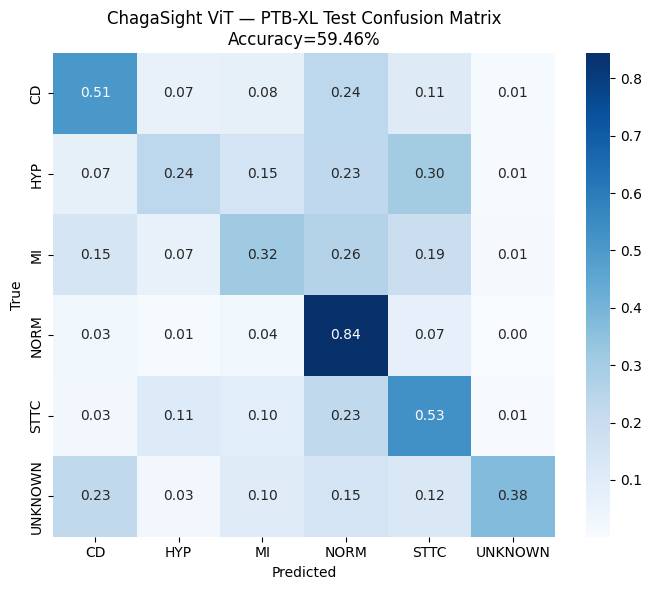

In [12]:
# ======================================================
# 08. Test Evaluation
# ======================================================

import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load best model checkpoint ---
model.load_state_dict(torch.load(CHECKPOINT_BEST, map_location=device))
model.eval()

test_preds, test_targets = [], []

with torch.no_grad(), torch.amp.autocast("cuda"):
    for xb, yb in test_loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        logits = model(xb)
        preds = logits.argmax(dim=1)
        test_preds.append(preds.cpu().numpy())
        test_targets.append(yb.cpu().numpy())

test_preds = np.concatenate(test_preds)
test_targets = np.concatenate(test_targets)

# --- Overall test accuracy ---
test_acc = (test_preds == test_targets).mean()
print(f"✅ Test accuracy: {test_acc:.4f}")

# --- Classification report ---
print("\n📋 Classification Report:")
print(classification_report(
    test_targets, test_preds,
    target_names=[idx_to_label[i] for i in range(num_classes)],
    digits=4
))

# --- Confusion matrix ---
cm = confusion_matrix(test_targets, test_preds, normalize="true")
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, cmap="Blues",
            xticklabels=[idx_to_label[i] for i in range(num_classes)],
            yticklabels=[idx_to_label[i] for i in range(num_classes)],
            fmt=".2f")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"ChagaSight ViT — PTB-XL Test Confusion Matrix\nAccuracy={test_acc:.2%}")
plt.tight_layout()
plt.show()


📊 Confusion matrix saved to: experiments\vit\results\vit_confusion_matrix.png


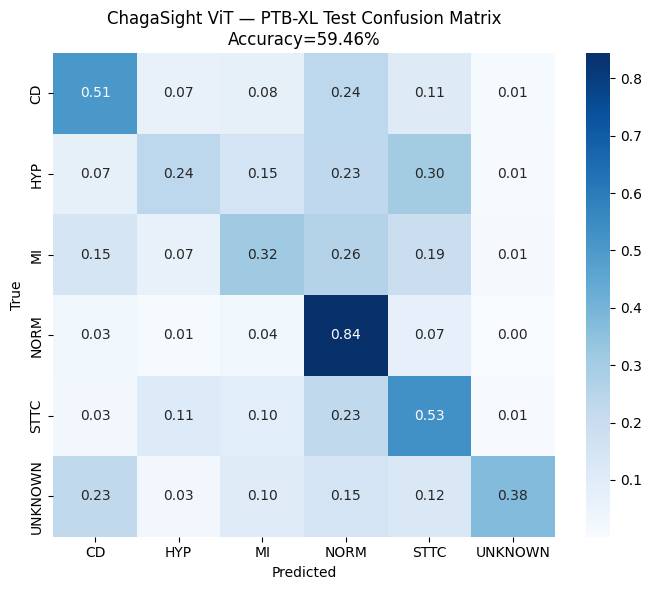

📄 Classification report saved to: experiments\vit\results\vit_classification_report.txt


In [13]:
# ======================================================
# 09. Save Confusion Matrix & Classification Report (Fixed)
# ======================================================

import os
from sklearn.metrics import classification_report

RESULTS_DIR = os.path.join("experiments", "vit", "results")
os.makedirs(RESULTS_DIR, exist_ok=True)

# Recreate the confusion matrix plot (since plt.show() clears it)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, cmap="Blues",
            xticklabels=[idx_to_label[i] for i in range(num_classes)],
            yticklabels=[idx_to_label[i] for i in range(num_classes)],
            fmt=".2f")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"ChagaSight ViT — PTB-XL Test Confusion Matrix\nAccuracy={test_acc:.2%}")
plt.tight_layout()

# --- Save before showing ---
cm_path = os.path.join(RESULTS_DIR, "vit_confusion_matrix.png")
plt.savefig(cm_path, dpi=300, bbox_inches="tight")
print(f"📊 Confusion matrix saved to: {cm_path}")

plt.show()  # show after saving

# --- Save classification report ---
report = classification_report(
    test_targets, test_preds,
    target_names=[idx_to_label[i] for i in range(num_classes)],
    digits=4
)
report_path = os.path.join(RESULTS_DIR, "vit_classification_report.txt")
with open(report_path, "w") as f:
    f.write(report)
print(f"📄 Classification report saved to: {report_path}")


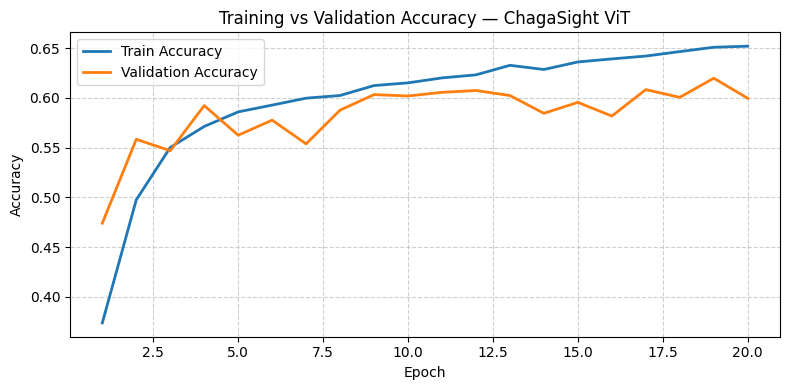

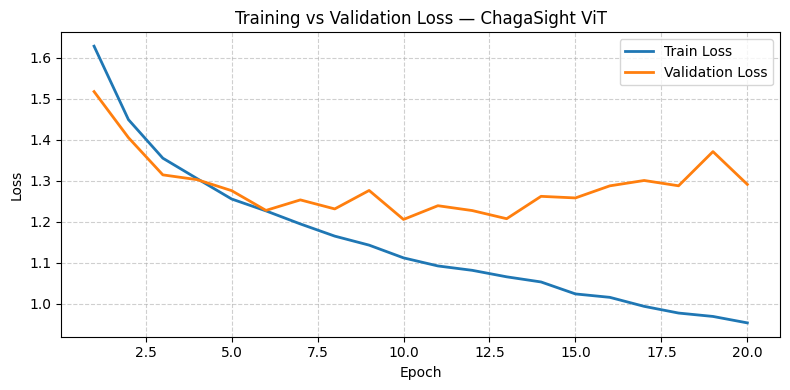


🏆 Best Epoch Summary:


epoch         19.000000
train_loss     0.969529
train_acc      0.650878
val_loss       1.371298
val_acc        0.619789
Name: 18, dtype: float64

In [14]:
# ======================================================
# 10. Training Behaviour Visualisation (Cleaned)
# ======================================================

import pandas as pd
import matplotlib.pyplot as plt

# --- Load and clean log ---
log = pd.read_csv(LOG_CSV)
log = log.drop_duplicates(subset=["epoch"], keep="last").reset_index(drop=True)

# --- Accuracy Plot ---
plt.figure(figsize=(8, 4))
plt.plot(log["epoch"], log["train_acc"], label="Train Accuracy", linewidth=2, color="#1f77b4")
plt.plot(log["epoch"], log["val_acc"], label="Validation Accuracy", linewidth=2, color="#ff7f0e")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy — ChagaSight ViT")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# --- Loss Plot ---
plt.figure(figsize=(8, 4))
plt.plot(log["epoch"], log["train_loss"], label="Train Loss", linewidth=2, color="#1f77b4")
plt.plot(log["epoch"], log["val_loss"], label="Validation Loss", linewidth=2, color="#ff7f0e")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss — ChagaSight ViT")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# --- Best Epoch Summary ---
best_row = log.loc[log["val_acc"].idxmax()]
print("\n🏆 Best Epoch Summary:")
display(best_row)


In [15]:
# ======================================================
# 11. Results Summary Table (For Research Report)
# ======================================================

import pandas as pd
from sklearn.metrics import f1_score

# --- Compute macro F1-score ---
macro_f1 = f1_score(test_targets, test_preds, average="macro")

# --- Create summary dictionary ---
summary_data = {
    "Model": ["ChagaSight ViT (PTB-XL)"],
    "Dataset": ["PTB-XL"],
    "Accuracy": [round(test_acc, 4)],
    "F1-Score (Macro)": [round(macro_f1, 4)],
    "Parameters (M)": [round(total_params_m, 2)],
    "Best Epoch": [int(best_row["epoch"])],
    "Train Accuracy": [round(best_row["train_acc"], 4)],
    "Val Accuracy": [round(best_row["val_acc"], 4)],
    "Train Loss": [round(best_row["train_loss"], 4)],
    "Val Loss": [round(best_row["val_loss"], 4)],
}

summary_df = pd.DataFrame(summary_data)
display(summary_df)

# --- Save summary CSV ---
summary_path = os.path.join(RESULTS_DIR, "vit_summary_table.csv")
summary_df.to_csv(summary_path, index=False)
print(f"💾 Summary table saved to: {summary_path}")


,Model,Dataset,Accuracy,F1-Score (Macro),Parameters (M),Best Epoch,Train Accuracy,Val Accuracy,Train Loss,Val Loss
0,ChagaSight ViT (PTB-XL),PTB-XL,0.5946,0.4783,3.32,19,0.6509,0.6198,0.9695,1.3713


💾 Summary table saved to: experiments\vit\results\vit_summary_table.csv
